# Load model package

In [2]:
import sys
sys.path.insert(1,'./src_VI/')
from ZIV import ZIV

# Load data simulation package

In [3]:
sys.path.insert(1,'./src_simulation/')
from data_sim import sim_tobit_data, show_sim

# Load other packages

In [4]:
import pandas as pd
import numpy as np

# Zero-inflated simulated data example

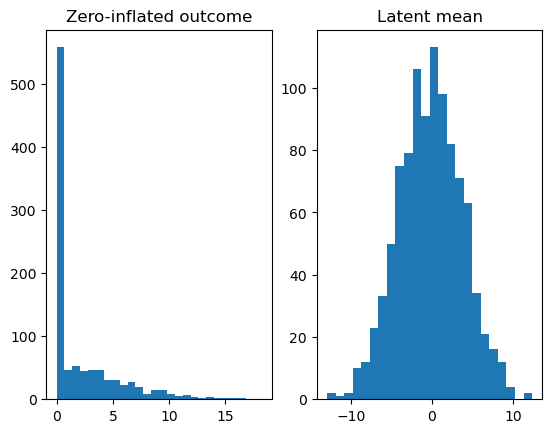

------------------------------------
Feature variance is 15.17962548241134
total variance is30.35925096482268
Fraction of variance explained is 0.5
------------------------------------


In [5]:
# Loading the data
data_sim = sim_tobit_data(n = 1000, p =50, p_causal = 20, 
                          rho = 0.1, var = 1, n_matrix = 1, h = 0.5, p_confound = 0)
z, X, Xs, latent_mean, var_feature, var_total, true_beta, y_star = data_sim.gen_data()
show_sim(z, latent_mean, var_total)
z_df = pd.DataFrame(z, columns = ['outcome'])
feature_df = pd.DataFrame(X, columns = ['c'+str(i) for i in range(1,X.shape[1]+1)])
data = pd.concat([z_df, feature_df], axis = 1)

In [6]:
# Adding categorical features that is included in the FVE calculation (null effect)
data['cate_feature_1'] = np.random.choice(range(1,4), data.shape[0], replace = True)
data['cate_feature_1'] = np.where(data['cate_feature_1'] == 1, 'C1', np.where(data['cate_feature_1'] == 2, 'C2', 'C3'))
data['cate_feature_2'] = np.where(np.random.binomial(1, 0.5, size = data.shape[0]), 'T', 'F')
# Add in two true beta for the additional categorical features
true_beta = np.concatenate([np.array([0,0, 0]), true_beta])
# Adding confounding categroical features (null effect)
data['cate_conf_1'] = np.random.choice(range(1,4), data.shape[0], replace = True)
data['cate_conf_1'] = np.where(data['cate_conf_1'] == 1, 'C1', np.where(data['cate_conf_1'] == 2, 'C2', 'C3'))
data['cate_conf_2'] = np.where(np.random.binomial(1, 0.5, size = data.shape[0]), 'T', 'F')

At iteration 0, the loss is 2832.2389884213303


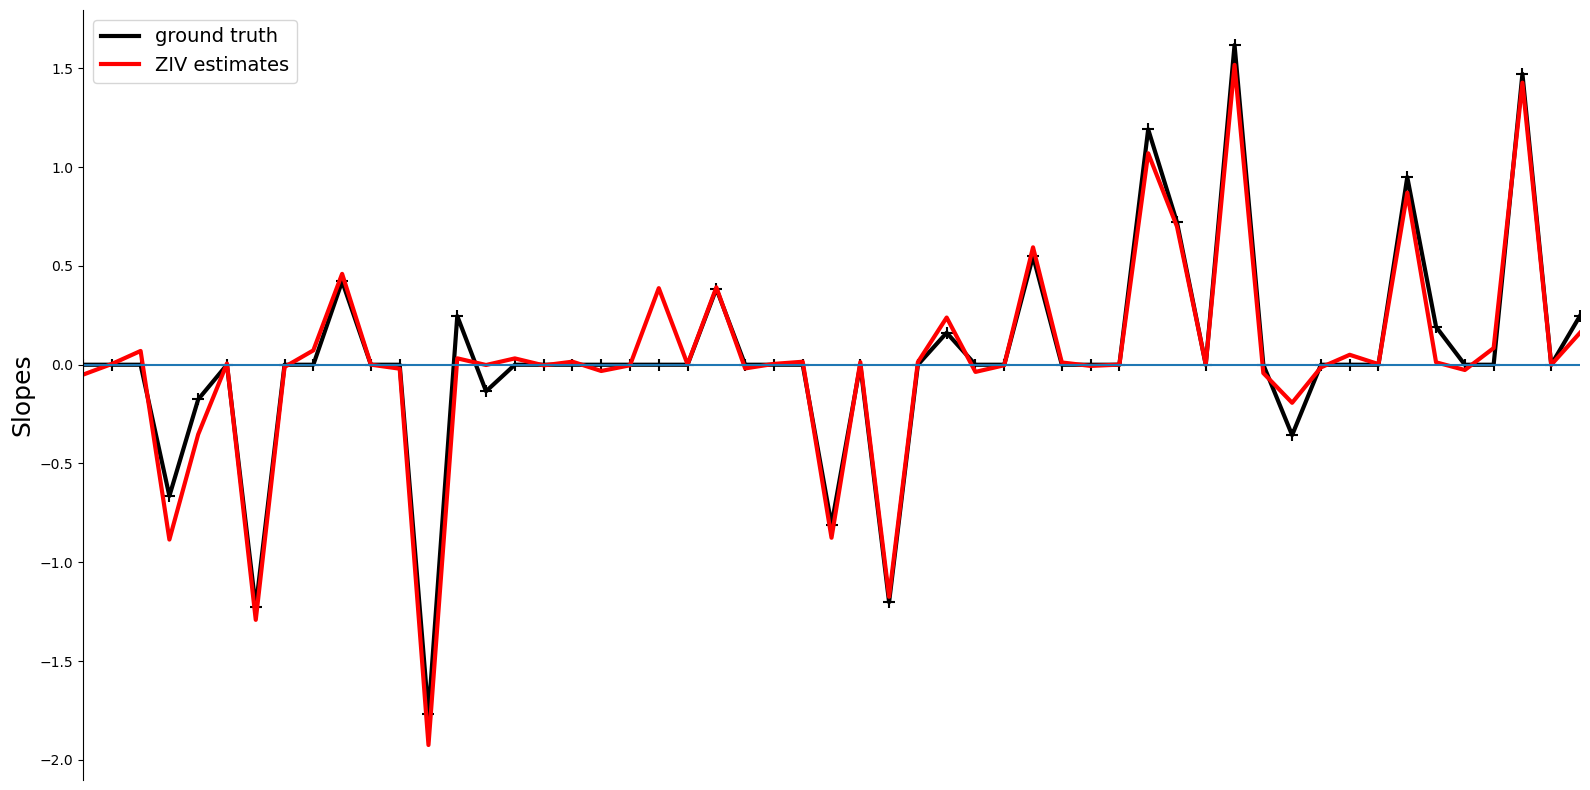

In [7]:
# Initialize and Fit the model
ziv = ZIV(data = data, outcome_name = 'outcome', 
          feature_conti_name = list(data.columns[1:51]), 
          feature_cate_name = ['cate_feature_1', 'cate_feature_2'],
          confounder_conti_name = [], 
          confounder_cate_name = ['cate_conf_1', 'cate_conf_2'],
          batch_size = None, device = 'cpu')
FVE_df, coefficient_df, train_prediction, train_error = ziv.fit(lr = 0.5, 
                                                                min_loss_stop_fraction_diff = 0.5, 
                                                                lr_schedule_step = 1000, lr_sch_gamma = 0.8, 
                                                                verbose = True, true_beta = true_beta)

In [10]:
# Latent Point Prediction
Y = ziv.predict(data)

In [11]:
# Transform it to the observed scale
Z = np.where(Y>0, Y, 0)

In [17]:
# prediction error on the training set
np.mean(np.abs(Z-z))

1.4859582407510201

# Inference results

In [13]:
# Total signal profile
FVE_df

{'FVE': [0.4964338457647556],
 'FVE_upper': [0.550162962956186],
 'FVE_lower': [0.440748582942259],
 'global_non_null': [0.39647807962525566],
 'global_non_null_upper': [0.5552106181641611],
 'global_non_null_lower': [0.25120907053967917],
 'feature_variance': [16.014297851424573],
 'noise_variance': [16.224167500310024]}

In [14]:
# Local feature profile for each feature
coefficient_df

,feature_names,beta,pi
0,cate_feature_1_C2,-0.217951,0.230395
1,cate_feature_1_C3,0.033239,0.118506
2,cate_feature_2_T,0.261471,0.266905
3,c1,-0.885658,0.999342
4,c2,-0.454086,0.776917
5,c3,0.067191,0.096474
6,c4,-1.291760,0.999825
7,c5,-0.087878,0.129598
8,c6,0.261478,0.278058
9,c7,0.510301,0.901506
